# Explainable AI

Explainable AI can be used to evaluate the trustworthiness of the model. It gives an indication about how the model makes the predicition. Even a seemingly well performing model, may actually be looking at unexpected attributes. For example a model detecting a wolf, may actually just be detecting snow. The performance would therefore be misleading. 

## Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Getting the model

#### Load model into memory

In [2]:
from tensorflow.keras.models import load_model
from efficientnet.tfkeras import EfficientNetB0

model_path = "deployment/model_07122022180601.h5" # replace this with the path to the model
model = load_model(model_path)

#### Investigate expected shape

In [3]:
from math import sqrt

input_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
expect_flattened_input = len(input_shape) == 2
img_pixel = int(sqrt(input_shape[1]/3) if expect_flattened_input else input_shape[1])

In [4]:
are_flat = "are" if expect_flattened_input else "are not"
print(f"the model expects images with size {img_pixel}*{img_pixel} which {are_flat} flattened out")

the model expects images with size 224*224 which are not flattened out


## Load images

#### Config on where to find the data

In [5]:
base_path = "data" 
downsampled_data = False
partition = "test"
num_images = 5

In [6]:
img_folder = base_path + "/" + partition + ("_downsampled" if downsampled_data else "")
groundtruth_file = base_path + "/ISIC_2020_2019_" + partition + ("_downsampled" if downsampled_data else "") + ".csv" 

#### Getting image(s)

In [7]:
from utilities import get_img_paths, load_data, split_predictors_target, unflatten_images_df

img_paths = get_img_paths(img_folder, num_images) 
df = load_data(img_paths, groundtruth_file, img_pixel=img_pixel)
X, y = split_predictors_target(df) 

if not expect_flattened_input:
    X = unflatten_images_df(X, img_pixel=img_pixel)

## Predict and explain images

#### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

import tensorflow as tf
import keras
import numpy

from utilities import random_state
np.random.seed(random_state())

#### Helper functions

In [9]:
# show most important superpixels 
def generate_prediction_sample(exp, 
                               exp_class, 
                               num_features=6, # max number of segments shown
                               min_weight = 0.001, # min weight that superpixel have to have to be included in result
                               positive_only = True, # only show pixels that contribute to a True predction
                               hide_background = True # show on black background instead of the picture
                              ):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    plt.figure()
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=positive_only, 
                                         num_features=num_features, 
                                         hide_rest=hide_background,
                                         min_weight=min_weight
                                        )
    
    plt.title(f"Highlight super-pixel, \nonly positive: {positive_only} hide background: {hide_background}")
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
    
# show how important each super-pixel is to get more granular explaianbility
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    plt.figure()
    plt.title("explanation heatmap")
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.axis('off')
    plt.show()

#### Generate predicitions

In [10]:
y_pred = model.predict(X)

#### Explain predictions

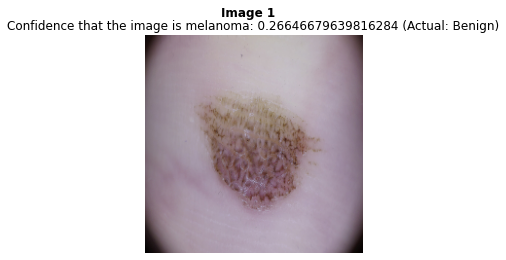

  0%|          | 0/1000 [00:00<?, ?it/s]

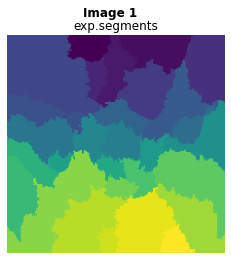

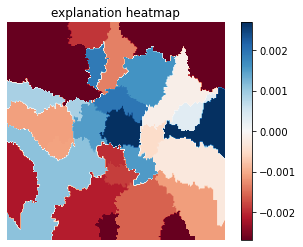

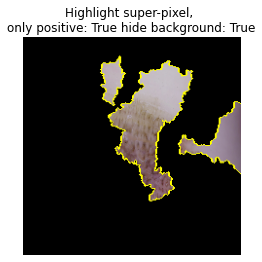

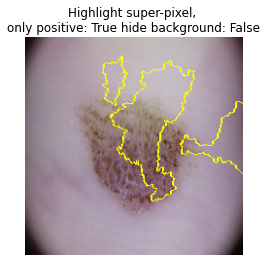

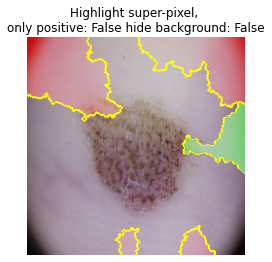

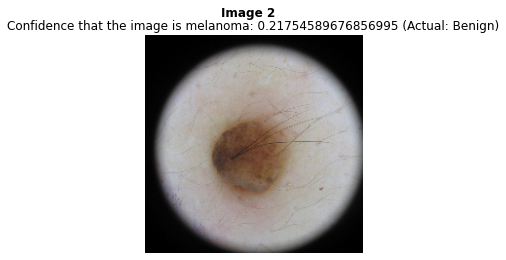

  0%|          | 0/1000 [00:00<?, ?it/s]

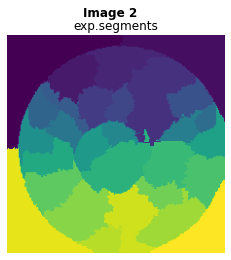

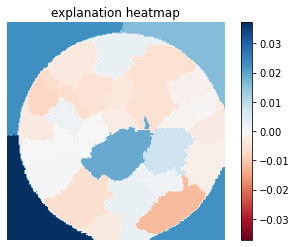

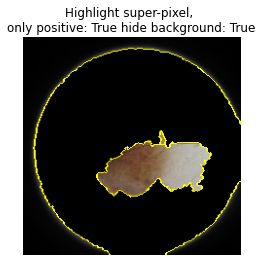

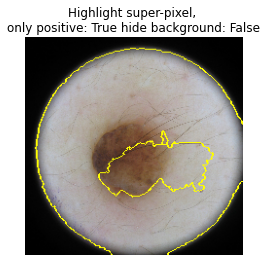

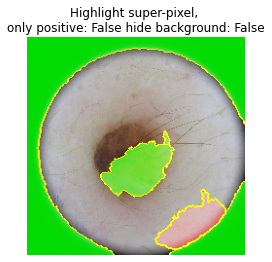

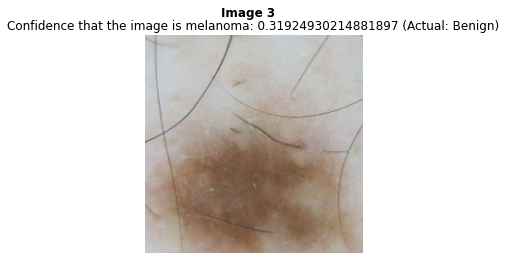

  0%|          | 0/1000 [00:00<?, ?it/s]

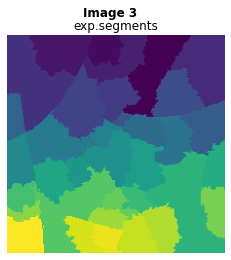

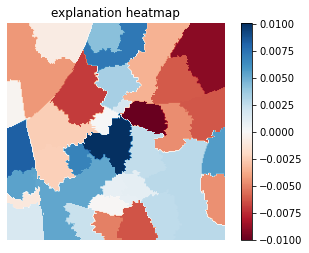

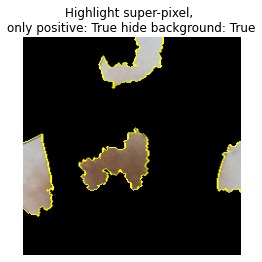

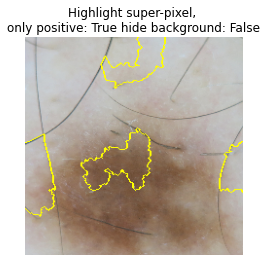

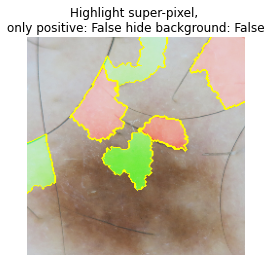

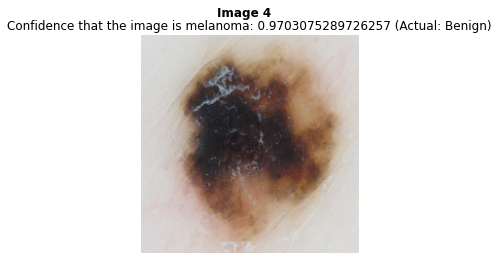

  0%|          | 0/1000 [00:00<?, ?it/s]

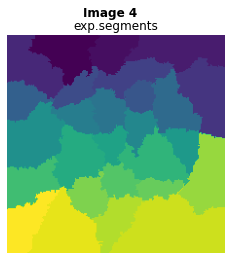

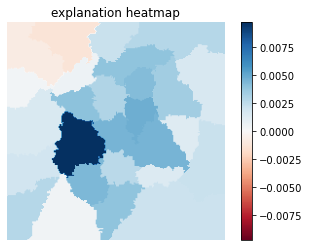

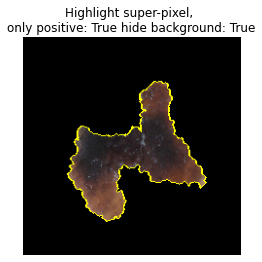

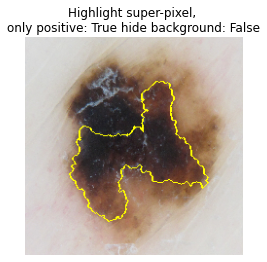

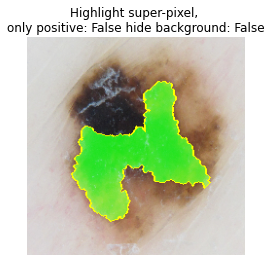

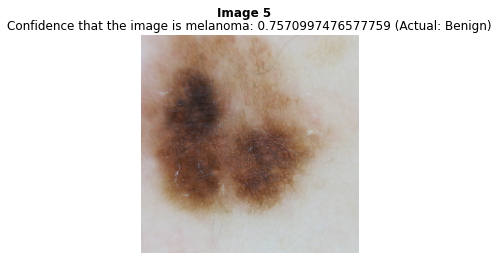

  0%|          | 0/1000 [00:00<?, ?it/s]

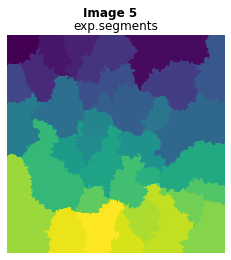

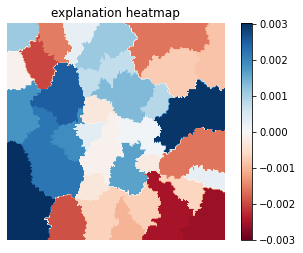

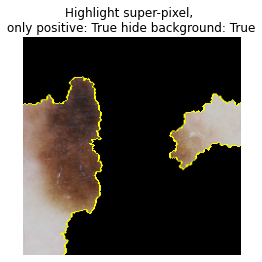

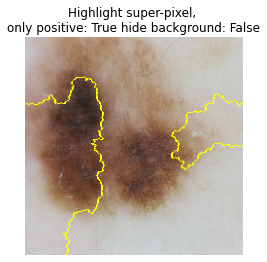

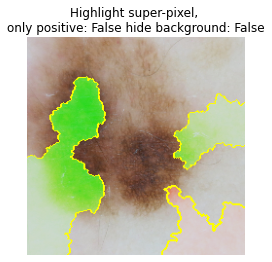

In [11]:
explainer = lime_image.LimeImageExplainer(random_state())

if expect_flattened_input:
    print("this will crash!!!")

for i in range(X.shape[0]):
    # output prediction
    title = f"Image {i+1}"
    actual = "Benign" if y[i] == 0 else "Malignant"
    prediction = f"Confidence that the image is melanoma: {y_pred[i][0]} (Actual: {actual})"
    img_to_display = X[i]

    # display image
    plt.figure()
    plt.title(prediction)
    plt.suptitle(title, fontweight ="bold")
    plt.imshow(img_to_display)
    plt.axis('off')
    plt.show()

    # explain image
    exp = explainer.explain_instance(
                             img_to_display, 
                             model.predict, 
                             hide_color=[0,1,0], # when a segment is hidden, the "hide_color" is the green because it is the color furthest away from human skin
                             num_samples=1000 # number of predictions that are run in order to determine segment importance
                            )
    
    # display segments
    plt.figure()
    plt.title("exp.segments")
    plt.suptitle(title, fontweight ="bold")
    plt.imshow(exp.segments)
    plt.axis('off')
    plt.show()

    # heat map of segments
    explanation_heatmap(exp, exp.top_labels[0])
    
    # highlight the contour of the positive segments on black background
    generate_prediction_sample(exp, exp.top_labels[0], positive_only = True, hide_background = True)

    # highlight the contour of the positive segments and include the background
    generate_prediction_sample(exp, exp.top_labels[0], positive_only = True, hide_background = False)

    # highlight the positive segments and negative segments
    generate_prediction_sample(exp, exp.top_labels[0], positive_only = False, hide_background = False)
    

  0%|          | 0/5 [00:00<?, ?it/s]

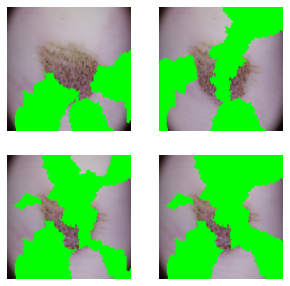

In [12]:
test_perturbed_images = True

if test_perturbed_images:
    from lime.wrappers import scikit_image
    import matplotlib.pyplot as plt
    import copy
    import pandas as pd

    # segmentation using quickshift algorithm
    segmentation_fn = scikit_image.SegmentationAlgorithm('quickshift', kernel_size=5,
                                                        max_dist=200, ratio=0.2,
                                                        random_seed=random_state())
    segments = segmentation_fn(X[0])

    hide_color=[0,1,0] # green!
    fudged_image = X[0].copy()
    fudged_image[:] = hide_color
    data,labels=explainer.data_labels(X[0], fudged_image, segments,
                                            classifier_fn=model.predict, num_samples=5,
                                            batch_size=10
                                            )
    
    def perturbed_images_generation(image,fudged_image,segments,data):
        rows = data
        imgs = []
        req_images=[]
        # Iterate through each of the row of the array called data
        for row in rows:
            # temp a copy of the original image
            temp = copy.deepcopy(X[0])
            # Finding the indexes of the zeros in each row
            zeros = np.where(row == 0)[0]
            # create an temporary array called mask same shape as of segments(here (256,256)) which contains all the values as False
            mask = np.zeros(segments.shape).astype(bool)
            # For each zero(off superpixel) in each row of data replace the image by the fudged_image 
            for z in zeros:
                mask[segments == z] = True
            temp[mask] = fudged_image[mask]
            imgs.append(temp)
            req_images.extend(imgs)
            imgs = []

        return req_images

     # Perturbed images
    perturbed_images=perturbed_images_generation(X[0],fudged_image,segments,data)

    # Calculate the distances between perturbed images and original image
    import sklearn
    distances = sklearn.metrics.pairwise_distances(
                data,
                data[0].reshape(1, -1),
                metric='cosine'
            ).ravel()

    # Find the top 3 closest perturbed images
    df=pd.DataFrame(distances,columns=['distance'])
    df1=df.sort_values(by='distance')
    df1=df1.drop_duplicates(keep='first')
    req_index=df1.index[0:5]

    # Plotting the original and top 3 closest perturbed images
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(5,5))
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax1.imshow(perturbed_images[req_index[1]])
    ax2.imshow(perturbed_images[req_index[2]])
    ax3.imshow(perturbed_images[req_index[3]])
    ax4.imshow(perturbed_images[req_index[4]])